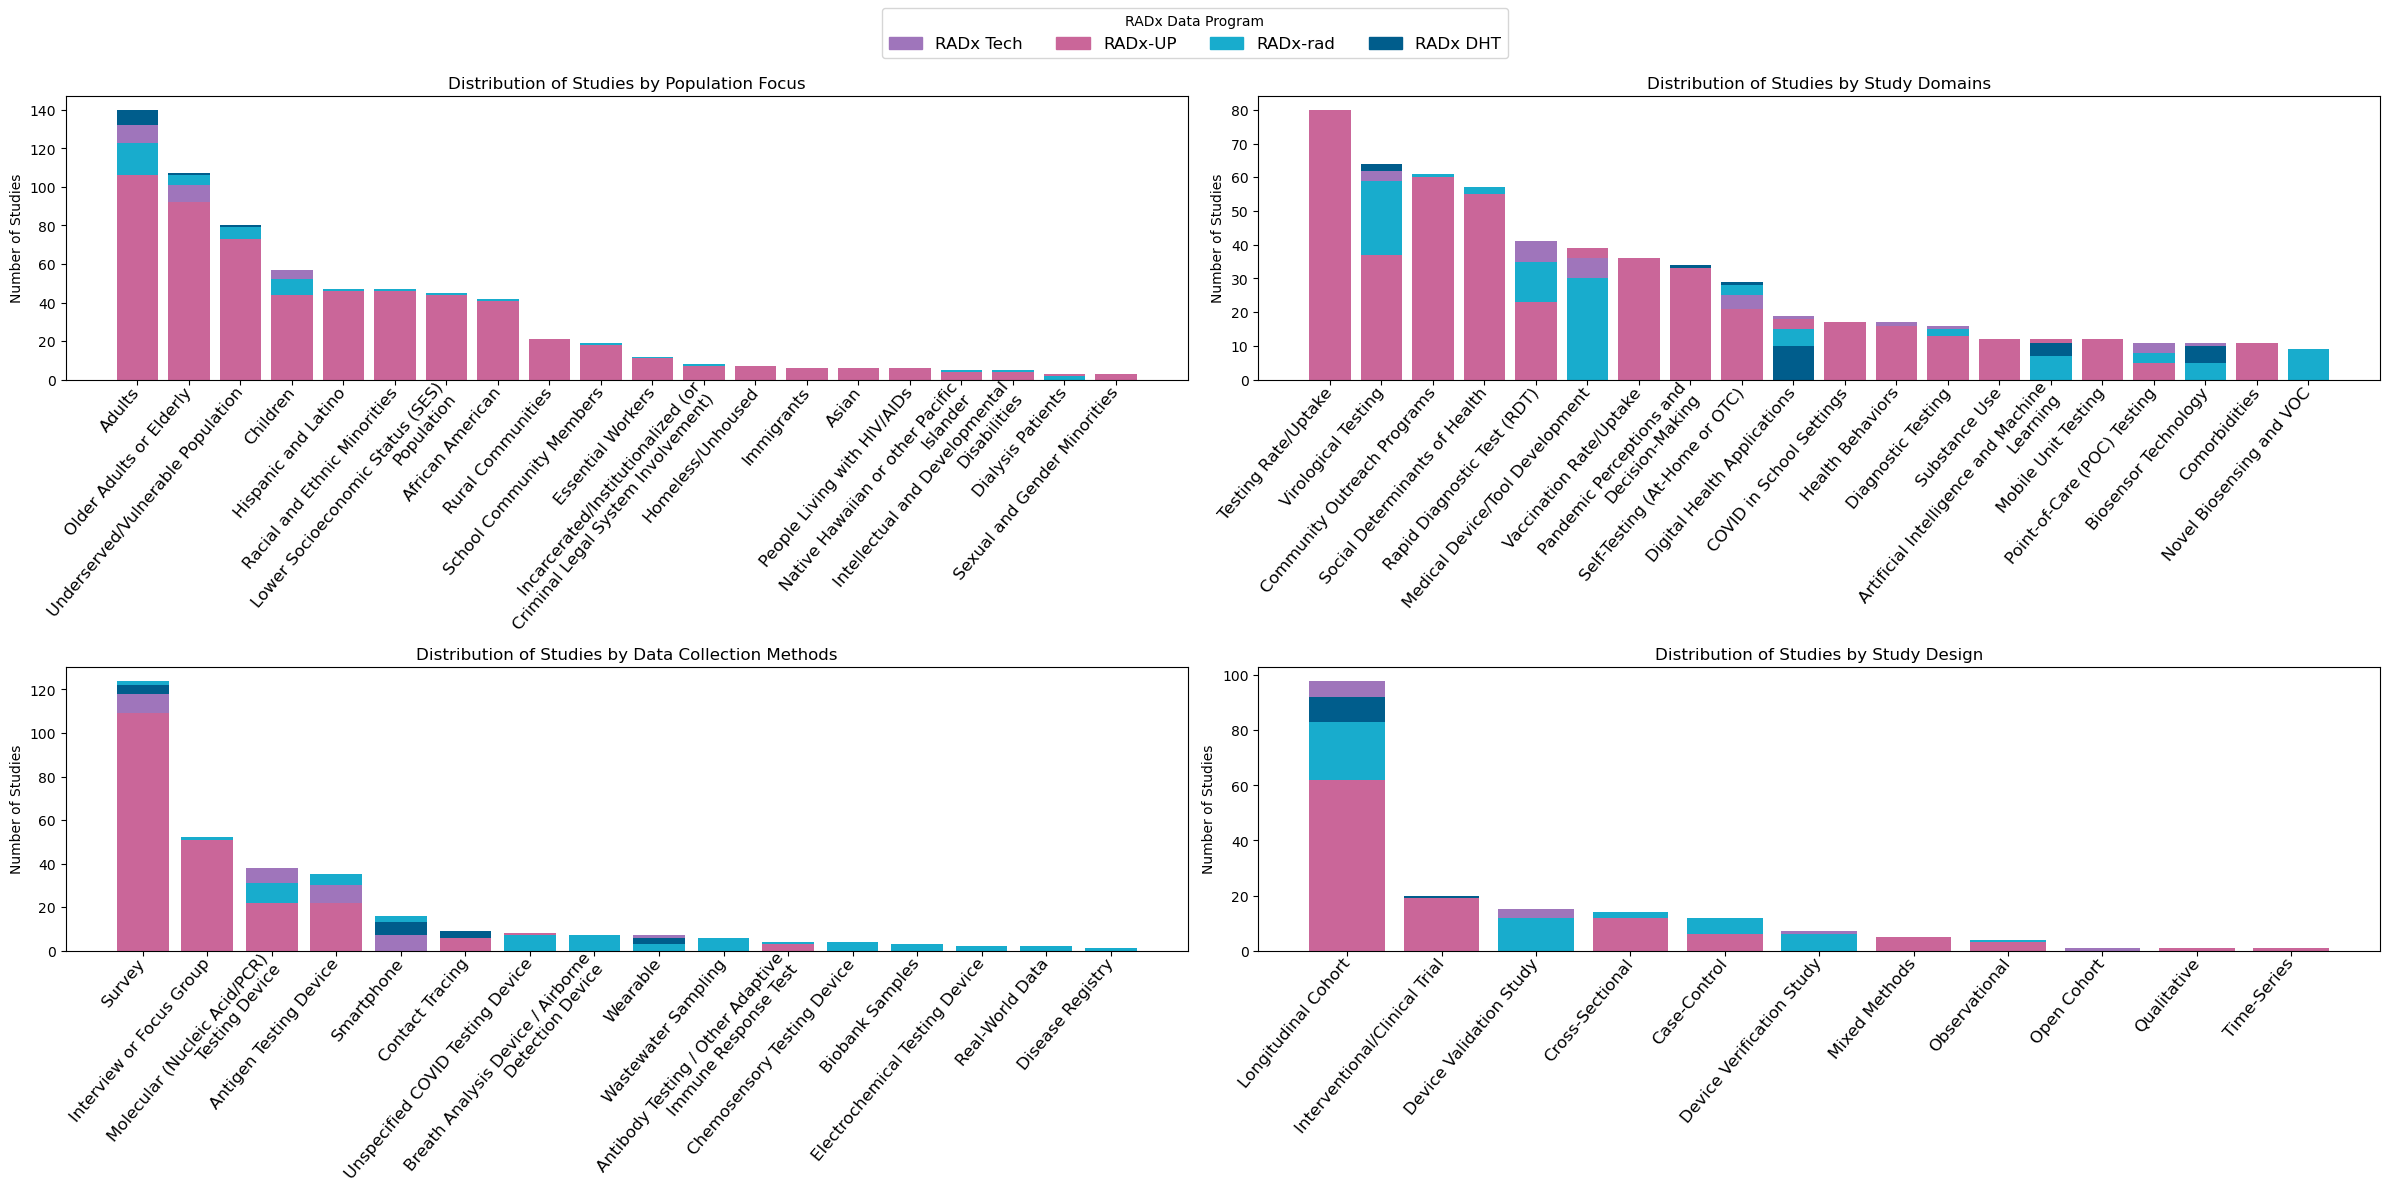

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the data
file_path = "StudyExplorerResults.csv"  # Replace with your file path
data = pd.read_csv(file_path, encoding="latin1")

# Process the data
data["Study Population Focus"] = data["Study Population Focus"].str.split("; ")
data["Study Domain"] = data["Study Domain"].str.split("; ")
data["Data Collection Method"] = data["Data Collection Method"].str.split("; ")

# Explode columns to have one value per row for analysis
exploded_population_focus = data.explode("Study Population Focus")
exploded_study_domain = data.explode("Study Domain")
exploded_data_collection = data.explode("Data Collection Method")

# Count occurrences for each category in each field
top_population_focus = exploded_population_focus["Study Population Focus"].value_counts().head(20)
top_study_domain = exploded_study_domain["Study Domain"].value_counts().head(20)
top_data_collection = exploded_data_collection["Data Collection Method"].value_counts().head(20)

# Prepare dataframes for stacked bar chart
def prepare_stacked_data(column_name, top_categories):
    exploded = data.explode(column_name)
    filtered = exploded[exploded[column_name].isin(top_categories.index)]
    grouped = filtered.groupby([column_name, "RADx Data Program"]).size().unstack(fill_value=0)
    # Ensure all programs are represented
    for program in ["RADx Tech", "RADx-UP", "RADx-rad", "RADx DHT"]:
        if program not in grouped.columns:
            grouped[program] = 0
    return grouped

stacked_population_focus = prepare_stacked_data("Study Population Focus", top_population_focus)
stacked_study_domain = prepare_stacked_data("Study Domain", top_study_domain)
stacked_data_collection = prepare_stacked_data("Data Collection Method", top_data_collection)
stacked_study_design = data.groupby(["Study Design", "RADx Data Program"]).size().unstack(fill_value=0)
# Ensure all programs are represented
for program in ["RADx Tech", "RADx-UP", "RADx-rad", "RADx DHT"]:
    if program not in stacked_study_design.columns:
        stacked_study_design[program] = 0

# Sort data by total sums (rows and columns)
def sort_stacked_data(data):
    # Sort columns (RADx Data Programs) by overall sum descending
    ordered_columns = data.sum().sort_values(ascending=False).index
    data = data[ordered_columns]
    # Sort rows (categories) by the total sum descending
    data = data.loc[data.sum(axis=1).sort_values(ascending=False).index]
    return data

sorted_population_focus = sort_stacked_data(stacked_population_focus)
sorted_study_domain = sort_stacked_data(stacked_study_domain)
sorted_data_collection = sort_stacked_data(stacked_data_collection)
sorted_study_design = sort_stacked_data(stacked_study_design)

# Define colors for RADx programs
radx_colors = {
    "RADx Tech": "#9f75bb", 
    "RADx-UP": "#ca6699",   
    "RADx-rad": "#18accd",   
    "RADx DHT": "#005d8c", 
}

# Wrapping function for long labels
def wrap_labels(labels, max_line_length=30):
    wrapped_labels = []
    for label in labels:
        words = label.split(' ')
        new_label = ''
        line = ''
        for word in words:
            if len(line + ' ' + word) <= max_line_length:
                line += ' ' + word if line else word
            else:
                new_label += line + '\n'
                line = word
        new_label += line
        wrapped_labels.append(new_label)
    return wrapped_labels

# Function to plot stacked bars with internal sorting
def plot_stacked_bars_with_internal_sorting(data, title, ylabel, colors=None, max_label_length=30, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(14, 6))  # Increased figure width
    else:
        fig = ax.figure

    # Name the index explicitly
    data.index.name = 'Category'

    # Reset index and melt
    data_long = data.reset_index().melt(id_vars='Category', var_name='RADx Program', value_name='Value')

    # Sort categories by total value descending
    category_totals = data_long.groupby('Category')['Value'].sum().sort_values(ascending=False)
    data_long['Category'] = pd.Categorical(data_long['Category'], categories=category_totals.index, ordered=True)

    # Get unique categories and positions
    categories = data_long['Category'].cat.categories
    category_positions = np.arange(len(categories))

    # Initialize bottoms for each category
    bottoms = np.zeros(len(categories))

    # Prepare a mapping from RADx Program to color
    if colors:
        color_map = colors
    else:
        color_map = {program: None for program in data_long['RADx Program'].unique()}

    # Plot bars for each category
    for idx, category in enumerate(categories):
        df_cat = data_long[data_long['Category'] == category]
        # Sort RADx Programs within each category by value descending
        df_cat = df_cat.sort_values('Value', ascending=False)
        for _, row in df_cat.iterrows():
            program = row['RADx Program']
            value = row['Value']
            if value > 0:
                ax.bar(idx, value, bottom=bottoms[idx],
                       label=program if (idx == 0 and bottoms[idx] == 0) else None,
                       color=color_map.get(program))
                bottoms[idx] += value

    # Format the plot
    wrapped_labels = wrap_labels(categories, max_label_length)
    ax.set_xticks(category_positions)
    ax.set_xticklabels(wrapped_labels, rotation=50, ha='right', va='center', rotation_mode='anchor', fontsize=12)
    ax.set_title(title)
    # Removed the x-axis label
    # ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    # Adjust layout to prevent labels from being cut off
    plt.tight_layout()

    return ax

# Function to plot 2x2 grid with the updated plotting function
def plot_stacked_bars_in_grid(data_list, titles, ylabel, colors=None, max_label_length=35):
    fig, axes = plt.subplots(2, 2, figsize=(24, 12))  # Increased figure size
    axes = axes.flatten()

    for i, data in enumerate(data_list):
        ax = axes[i]
        plot_stacked_bars_with_internal_sorting(
            data,
            title=titles[i],
            ylabel=ylabel,
            colors=colors,
            max_label_length=max_label_length,
            ax=ax
        )

    # Add a single legend for all subplots
    handles = []
    labels = []
    for program in radx_colors.keys():
        handles.append(plt.Rectangle((0, 0), 1, 1, color=radx_colors[program]))
        labels.append(program)
    fig.legend(handles, labels, title="RADx Data Program", loc='upper center', ncol=4, fontsize=12)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    output_file = "outputs/bottom-diagonal-labels.png"
    plt.savefig(output_file, format="png", dpi=300, bbox_inches='tight')
    plt.show()

# Data and titles for the grid
data_list = [
    sorted_population_focus,
    sorted_study_domain,
    sorted_data_collection,
    sorted_study_design
]

titles = [
    "Distribution of Studies by Population Focus",
    "Distribution of Studies by Study Domains",
    "Distribution of Studies by Data Collection Methods",
    "Distribution of Studies by Study Design"
]

# Plot all charts in a 2x2 grid
plot_stacked_bars_in_grid(
    data_list,
    titles,
    ylabel="Number of Studies",
    colors=radx_colors
)
